* Explore proper fitting methods to the noisy and gappy time series over Thai Binh
* Evaluate the fitting results againt the field data of cropy yield

In [1]:
import os
import sys
import itertools
import glob

import numpy as np
import pandas as pd
from osgeo import gdal, gdal_array, osr, ogr

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1

import seaborn as sns

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")
dpi = 300

In [3]:
import plotly.plotly as pply
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
import plotly.tools

In [4]:
import geo_ts as gt

In [65]:
# input csv file name
var_names = ['ndvi', 'evi', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2']
csv_files = ['../results/thai_binh_field_subp_ts_{0:s}_fuse_at.csv'.format(varn) for varn in var_names]

csvf_ts_ndvi_sg = '../results/thai_binh_field_subp_ts_ndvi_sg.csv'
csvf_ts_ndvi_fuse_terra = '../results/thai_binh_field_subp_ts_ndvi_fuse_terra.csv'

csvf_ts_alos_hh = '../results/thai_binh_field_subp_ts_alos_hh.csv'
csvf_ts_alos_hv = '../results/thai_binh_field_subp_ts_alos_hv.csv'

In [69]:
ts_data_list = [pd.read_csv(csvf, header=[0, 1], index_col=0).sort_index().sort_index(axis=1) for csvf in csv_files]
ts_ndvi_fuse_aq = ts_data_list[0]
ts_evi_fuse_aq = ts_data_list[1]

ts_ndvi_sg = pd.read_csv(csvf_ts_ndvi_sg, header=[0, 1], index_col=0).sort_index().sort_index(axis=1)
ts_ndvi_sg.columns = ts_ndvi_sg.columns.droplevel('type').astype(int)
ts_ndvi_sg = ts_ndvi_sg.sort_index(axis=1)

ts_ndvi_fuse_terra = pd.read_csv(csvf_ts_ndvi_fuse_terra, header=[0, 1], index_col=0).sort_index().sort_index(axis=1)
ts_ndvi_fuse_terra.columns = ts_ndvi_fuse_terra.columns.droplevel('type').astype(int)
ts_ndvi_fuse_terra = ts_ndvi_fuse_terra.sort_index(axis=1)

ts_alos_hh = pd.read_csv(csvf_ts_alos_hh, header=0, index_col=0).sort_index().sort_index(axis=1)
ts_alos_hh.columns = ts_alos_hh.columns.astype(int)
ts_alos_hh = ts_alos_hh.sort_index(axis=1)

ts_alos_hv = pd.read_csv(csvf_ts_alos_hv, header=0, index_col=0).sort_index().sort_index(axis=1)
ts_alos_hv.columns = ts_alos_hv.columns.astype(int)
ts_alos_hv = ts_alos_hv.sort_index(axis=1)

In [7]:
no_data = -9999

## Calculate GCVI

In [8]:
invalid_flag = (ts_data_list[5] == no_data) | (ts_data_list[3] == no_data)

ts_gcvi = ts_data_list[5]/ts_data_list[3] - 1

ts_gcvi[invalid_flag] = no_data

In [9]:
ts_ndvi_fuse_terra[ts_ndvi_fuse_terra<=0.1] = no_data
ts_ndvi_sg[ts_ndvi_sg<=0.1] = no_data
ts_ndvi_fuse_aq[ts_ndvi_fuse_aq<=0.1] = no_data
ts_evi_fuse_aq[ts_evi_fuse_aq<=0.1] = no_data

## Merge fusion and actual observation

In [10]:
def mergeFuseObs(ts_data):
    uniq_doy, cnt = np.unique(ts_data.columns.droplevel('type').values, return_counts=True)
    merge_arr = np.zeros((len(ts_data), len(uniq_doy))) + no_data
    merge_arr = pd.DataFrame(merge_arr, columns=uniq_doy, index=ts_data.index)
    for col, n in zip(uniq_doy, cnt):
        if n>1:
            tmp = [ts_data.loc[ind, ('obs', col)] if ts_data.loc[ind, ('obs', col)]!=no_data else ts_data.loc[ind, ('fuse', col)] for ind in merge_arr.index]
            merge_arr.loc[:, col] = tmp
        else:
            merge_arr.loc[:, col] = ts_data.loc[:, ('obs', col)] if ('obs', col) in ts_data.columns else ts_data.loc[:, ('fuse', col)]
    return merge_arr    

In [11]:
ts_ndvi_fuse_aq_merge = mergeFuseObs(ts_ndvi_fuse_aq)
ts_evi_fuse_aq_merge = mergeFuseObs(ts_evi_fuse_aq)

ts_gcvi_merge = mergeFuseObs(ts_gcvi)

In [12]:
ts_ndvi_fuse_aq_merge.columns = ts_ndvi_fuse_aq_merge.columns.astype(int)
ts_ndvi_fuse_aq_merge = ts_ndvi_fuse_aq_merge.sort_index(axis=1)

ts_evi_fuse_aq_merge.columns = ts_evi_fuse_aq_merge.columns.astype(int)
ts_evi_fuse_aq_merge = ts_evi_fuse_aq_merge.sort_index(axis=1)

ts_gcvi_merge.columns = ts_gcvi_merge.columns.astype(int)
ts_gcvi_merge = ts_gcvi_merge.sort_index(axis=1)

## Read field data of crop yield

In [13]:
crop_yield_field_file = "/media/sf_Workspace/data/projects/kaiyu-adb-crop/vietnam-field/Thai_Binh_select_variables_crop_cutting.xlsx"
cls_map_file = "/media/sf_Workspace/data/projects/kaiyu-adb-crop/vietnam-cls/vietnam_thai_bin_cls_rf_lsat_scenes.img"

crop_yield_field = pd.read_excel(crop_yield_field_file, sheetname=0, \
                                 index_col=2)

colname = crop_yield_field.columns.values
colname[2] = "lat_m" # mesh lat
colname[3] = "lon_m" # mesh lon
colname[4] = "lat_s" # subplot lat
colname[5] = "lon_s" # subplot lon
colname[7] = "yield_field" # field measured yield
crop_yield_field.columns = colname

geo_points = pd.DataFrame(np.zeros((len(crop_yield_field), 2)), index=crop_yield_field.index, columns=['lon', 'lat'])
geo_points.loc[:, 'lat'] = crop_yield_field.loc[:, 'lat_s']
geo_points.loc[:, 'lon'] = crop_yield_field.loc[:, 'lon_s']

proj_points = pd.DataFrame(np.zeros((len(geo_points), 2)), index=geo_points.index, columns=['x', 'y'])
for k in proj_points.index:
    tmp = gt.geo2Proj(cls_map_file, geo_points.loc[k, 'lon'], geo_points.loc[k, 'lat'])
    proj_points.loc[k, 'x'] = tmp[0]
    proj_points.loc[k, 'y'] = tmp[1]
    
img_points = pd.DataFrame(np.zeros((len(geo_points), 2)), index=geo_points.index, columns=['sample', 'line'])
for k in img_points.index:
    tmp = gt.geo2Pixel(cls_map_file, geo_points.loc[k, 'lon'], geo_points.loc[k, 'lat'], ret_int=False)
    img_points.loc[k, 'sample'] = tmp[0]
    img_points.loc[k, 'line'] = tmp[1]

subp_imgsize = 2.5/30
img_points_ur = img_points.copy()
img_points_ur.loc[:, 'sample'] = (img_points.loc[:, 'sample']+subp_imgsize).astype(int)
img_points_ur.loc[:, 'line'] = (img_points.loc[:, 'line']-subp_imgsize).astype(int)

img_points_ll = img_points.copy()
img_points_ll.loc[:, 'sample'] = img_points.loc[:, 'sample'].astype(int)
img_points_ll.loc[:, 'line'] = img_points.loc[:, 'line'].astype(int)

img_points_ul = img_points.copy()
img_points_ul.loc[:, 'sample'] = (img_points.loc[:, 'sample']).astype(int)
img_points_ul.loc[:, 'line'] = (img_points.loc[:, 'line']-subp_imgsize).astype(int)

img_points_lr = img_points.copy()
img_points_lr.loc[:, 'sample'] = (img_points.loc[:, 'sample']+subp_imgsize).astype(int)
img_points_lr.loc[:, 'line'] = (img_points.loc[:, 'line']).astype(int)

img_points_ctr = img_points.copy()
img_points_ctr.loc[:, 'sample'] = (img_points.loc[:, 'sample']+0.5*subp_imgsize).astype(int)
img_points_ctr.loc[:, 'line'] = (img_points.loc[:, 'line']-0.5*subp_imgsize).astype(int)

## Read classification map

In [14]:
from classify_image import ImageClassifier

In [15]:
ic = ImageClassifier()
cls_map = ic.readRaster(cls_map_file)[0][0]

cls_map_profile = gt.getRasterMetaGdal(cls_map_file)

## Select field subplots falling into our image extent

In [16]:
cls_map_meta = gt.getRasterMetaGdal(cls_map_file)

ncols = cls_map_meta['RasterXSize']
nrows = cls_map_meta['RasterYSize']

in_subp_flag = reduce(np.logical_and, (img_points_ur.loc[:, 'sample']>=0, img_points_ur.loc[:, 'sample']<ncols, \
                                       img_points_ur.loc[:, 'line']>=0, img_points_ur.loc[:, 'line']<nrows, \
                                       img_points_ll.loc[:, 'sample']>=0, img_points_ll.loc[:, 'sample']<ncols, \
                                       img_points_ll.loc[:, 'line']>=0, img_points_ll.loc[:, 'line']<nrows))
print crop_yield_field.loc[np.logical_not(in_subp_flag), :]

crop_yield_field = crop_yield_field.loc[in_subp_flag, :]

geo_points = geo_points.loc[in_subp_flag, :]
proj_points = proj_points.loc[in_subp_flag, :]
img_points = img_points.loc[in_subp_flag, :]
img_points_ur = img_points_ur.loc[in_subp_flag, :]
img_points_ll = img_points_ll.loc[in_subp_flag, :]
img_points_ul = img_points_ur.loc[in_subp_flag, :]
img_points_lr = img_points_ll.loc[in_subp_flag, :]
img_points_ctr = img_points_ctr.loc[in_subp_flag, :]

single_pix_subp_flag = np.logical_and(img_points_ur.loc[:, 'sample']==img_points_ll.loc[:, 'sample'], \
                                      img_points_ur.loc[:, 'line']==img_points_ll.loc[:, 'line'])

            mesh_id plot_id     lat_m      lon_m      lat_s  lon_s variety  \
full_id                                                                      
017850-p10    17850     p10  20.62202  106.37985  20.621892    106    BC15   

            yield_field  
full_id                  
017850-p10  3609.709322  


In [17]:
# get the geolocation of subplot center
geo_points_ctr = pd.DataFrame(np.zeros((len(img_points_ctr), 2)), index=img_points_ctr.index, columns=['lon', 'lat'])
for k in geo_points_ctr.index:
    tmp = gt.pixel2Geo(cls_map_file, img_points_ctr.loc[k, 'sample'], img_points_ctr.loc[k, 'line'])
    geo_points_ctr.loc[k, 'lon'] = tmp[0]
    geo_points_ctr.loc[k, 'lat'] = tmp[1]
    
# get the projection coordinates of subplot centers
proj_points_ctr = pd.DataFrame(np.zeros((len(img_points_ctr), 2)), index=img_points_ctr.index, columns=['x', 'y'])
for k in proj_points_ctr.index:
    tmp = gt.pixel2Proj(cls_map_profile['GeoTransform'], img_points_ctr.loc[k, 'sample'], img_points_ctr.loc[k, 'line'])
    proj_points_ctr.loc[k, 'x'] = tmp[0]
    proj_points_ctr.loc[k, 'y'] = tmp[1]

## Determine a buffer zone of pure crop pixels

In [23]:
# Select subplots with four corners all in crop class pixels

cond_list = [cls_map[img_points_ctr.loc[:, 'line']+line_shift, img_points_ctr.loc[:, 'sample']+sample_shift]==1 \
             for line_shift in (-1, 0, 1) for sample_shift in (-1, 0, 1)]

crop_pix_flag = reduce(np.logical_and, cond_list)
single_crop_pix_flag = cls_map[img_points_ctr.loc[:, 'line'], img_points_ctr.loc[:, 'sample']]==1

In [118]:
print len(crop_pix_flag)
print np.sum(crop_pix_flag)
print np.sum(single_crop_pix_flag)
print len(crop_pix_flag) - np.sum(single_crop_pix_flag)

255
134
220
35


In [24]:
img_points = pd.DataFrame(np.zeros((len(geo_points), 2)), index=geo_points.index, columns=['sample', 'line'])
for k in img_points.index:
    tmp = gt.geo2Pixel(cls_map_file, geo_points.loc[k, 'lon'], geo_points.loc[k, 'lat'], ret_int=False)
    img_points.loc[k, 'sample'] = tmp[0]
    img_points.loc[k, 'line'] = tmp[1]

In [25]:
pix_frac_thresh = 0.4

In [26]:
tmp_flag = np.logical_and((np.ceil(img_points) - img_points)>pix_frac_thresh, (img_points-np.floor(img_points))>pix_frac_thresh)
pix_frac_flag = tmp_flag.all(axis=1)

## Output field subplots and selected ones to shape files

In [27]:
field_subp_shp = '/home/zhan/Windows-Shared/Workspace/data/projects/kaiyu-adb-crop/vietnam-field/thai_binh_crop_field_subp.shp'

In [30]:
# set up the shapefile driver
driver = ogr.GetDriverByName("ESRI Shapefile")

# create the data source
data_source = driver.CreateDataSource(field_subp_shp)

# create the spatial reference, WGS84
srs = osr.SpatialReference()
srs.ImportFromWkt(cls_map_profile['ProjectionRef'])

layer = data_source.CreateLayer("field_subp", srs, ogr.wkbPoint)
# Length of field name cannot be more than 10 characters for ESRI shapefile
field = ogr.FieldDefn("Name", ogr.OFTString)
field.SetWidth(16)
layer.CreateField(field)
layer.CreateField(ogr.FieldDefn("Latitude", ogr.OFTReal))
layer.CreateField(ogr.FieldDefn("Longitude", ogr.OFTReal))
layer.CreateField(ogr.FieldDefn("Sample", ogr.OFTInteger))
layer.CreateField(ogr.FieldDefn("Line", ogr.OFTInteger))
layer.CreateField(ogr.FieldDefn("FieldYield", ogr.OFTReal))
layer.CreateField(ogr.FieldDefn("SelectFlag", ogr.OFTInteger))

# Process the text file and add the attributes and features to the shapefile
for n in range(len(geo_points_ctr)):
    key = geo_points_ctr.index[n]
    # create the feature
    feature = ogr.Feature(layer.GetLayerDefn())
    # Set the attributes
    feature.SetField("Name", "{0:s}".format(key))
    feature.SetField("Latitude", geo_points_ctr.loc[key, 'lat'])
    feature.SetField("Longitude", geo_points_ctr.loc[key, 'lon'])
    feature.SetField("Sample", img_points_ctr.loc[key, 'sample'])
    feature.SetField("Line", img_points_ctr.loc[key, 'line'])
    feature.SetField('FieldYield', crop_yield_field.loc[key, 'yield_field'])
    if crop_pix_flag[n]:
        feature.SetField('SelectFlag', 0)
    elif single_crop_pix_flag[n]:
        feature.SetField('SelectFlag', 1)
    else:
        feature.SetField('SelectFlag', 3)
        
    # create the WKT for the feature using Python string formatting
    wkt = "POINT({0:f} {1:f})".format(float(proj_points_ctr.loc[key, 'x']), float(proj_points_ctr.loc[key, 'y']))

    # Create the point from the Well Known Txt
    point = ogr.CreateGeometryFromWkt(wkt)

    # Set the feature geometry using the point
    feature.SetGeometry(point)
    # Create the feature in the layer (shapefile)
    layer.CreateFeature(feature)
    # Destroy the feature to free resources
    feature.Destroy()

# Destroy the data source to free resources
data_source.Destroy()

## Fitting trial 1, fit a quadratic curve to a few points around DOY 250  after visual inspection of a lot of time series. 

In [31]:
def quadPeak(ts_data, row_key, beg_doy, end_doy, no_data=-9999, max_iter=100, diff_thresh=1):
    ts_section = ts_data.loc[row_key, beg_doy:end_doy]

    tmp_ind = np.where(ts_section != no_data)[0]
    y0 = ts_section.values[tmp_ind]
    x0 = ts_section.index.values[tmp_ind]
    
    x = np.copy(x0)
    y = np.copy(y0)
    for i in range(max_iter):    
        coef = np.polyfit(x, y, 2)
        quad_func = np.poly1d(coef)
        xfit = x0
        yfit = quad_func(xfit)
        ydiff = yfit - y0
        tmp_flag = ydiff < diff_thresh
        if np.sum(tmp_flag) == 0:
            break
        x = x0[tmp_flag]
        y = y0[tmp_flag]

    peak_x = -0.5*coef[1]/coef[0]
    if coef[0] < 0:
        peak_y = quad_func(peak_x)
    else:
        peak_y = 0
    
    max_y = np.max(y)
    return peak_x, peak_y, quad_func, max_y

In [32]:
beg_doy = 225
end_doy = 300

In [33]:
ts_data = ts_ndvi_fuse_terra
# ts_data = ts_gcvi_merge

peak_x, peak_y, quad_func, max_y = zip(*[quadPeak(ts_data, rowk, beg_doy, end_doy) for rowk in ts_data.index])
peak_x = np.array(peak_x)
peak_y = np.array(peak_y)
max_y = np.array(max_y)

In [34]:
invalid_ind = np.where(np.logical_or(peak_x<beg_doy, peak_x>end_doy))[0]
invalid_keys = ts_data.index[invalid_ind]
print invalid_keys, len(invalid_keys)

Index([u'004622-p04', u'013541-p04', u'013541-p10', u'015625-p06',
       u'015625-p14', u'017745-p18', u'018042-p15', u'024064-p10',
       u'027474-p02', u'060116-p06', u'060116-p10', u'060116-p16',
       u'060116-p19'],
      dtype='object', name=u'full_id') 13


In [103]:
np.where(y != no_data)[0].shape

(80,)

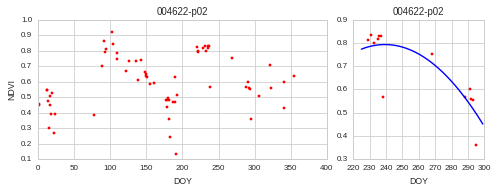

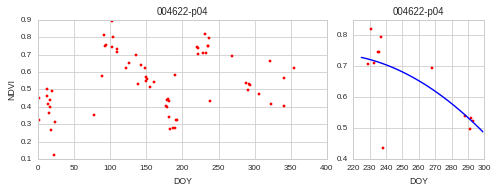

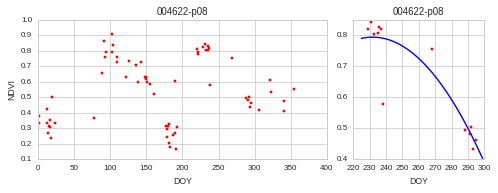

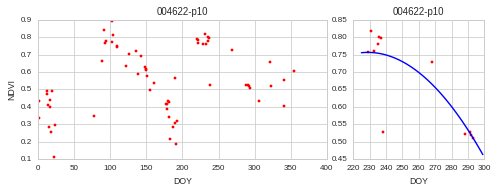

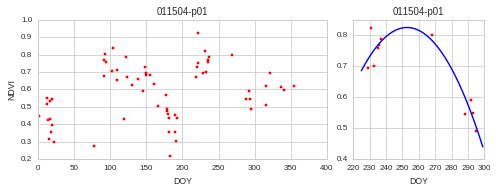

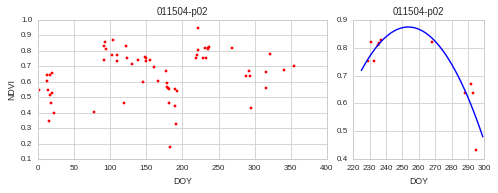

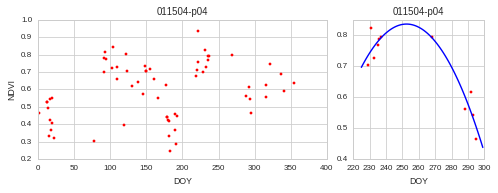

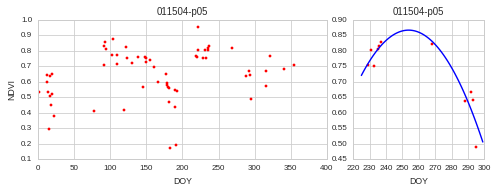

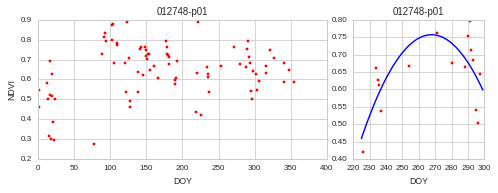

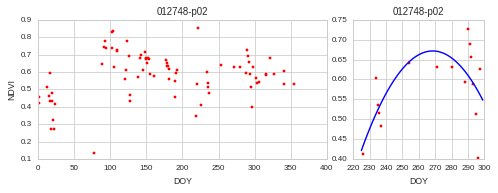

In [115]:
start_ind = 0
select_ind = np.arange(start_ind, start_ind+10, dtype=int)
select_keys = ts_data.index[select_ind]
select_ind = np.where(np.in1d(ts_data.index, select_keys))[0]
# for i, k in zip(invalid_ind, invalid_keys):
for i, k in zip(select_ind, select_keys):
#     fig, (ax1, ax2) = plt.subplots(1, 2)
    fig = plt.figure(figsize=(8, 2.5))
    ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1)
    
    ts_section = ts_data.loc[k, beg_doy:end_doy]
    tmp_ind = np.where(ts_section != no_data)[0]
    y = ts_section.values[tmp_ind]
    x = ts_section.index.values[tmp_ind]
    ax2.plot(x, y, '.r')
    xfit = np.arange(beg_doy, end_doy)
    ax2.plot(xfit, quad_func[i](xfit), '-b')
    plt.setp(ax2, title=k, xlabel='DOY')
    
    y = ts_data.loc[k, :]
    x = y.index.values
    y = y.values
    tmp_ind = np.where(y != no_data)[0]
    x = x[tmp_ind]
    y = y[tmp_ind]
    ax1.plot(x, y, '.r')
    plt.setp(ax1, title=k, xlabel='DOY', ylabel='NDVI')
    
    plt.savefig('../figures/ts_sectional_quad_fit_{0:s}.png'.format(k), dpi=300, bbox_inches='tight', pad_inches=0.)

## Plot crop yield against peak NDVI from quadratic fit

[ 12.51243715   0.           0.50924194   0.57161862   0.67937962
   0.64132325   0.72958082   0.60747358   0.60473438   0.66441201
   0.66945386] full_id
013541-p04    3279.460000
013541-p10    3618.175676
031939-p02    4411.798125
035054-p08    2099.041818
039753-p18    3193.361811
043388-p06    3142.641270
043388-p10    3134.815000
045114-p05    2972.651944
045114-p22    3734.532642
072557-p10    4582.939508
072557-p13    4530.203711
Name: yield_field, dtype: float64


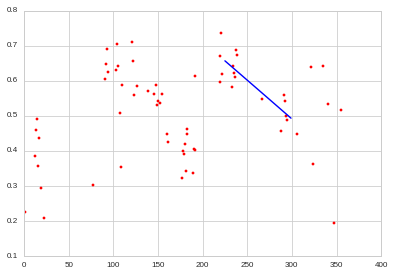

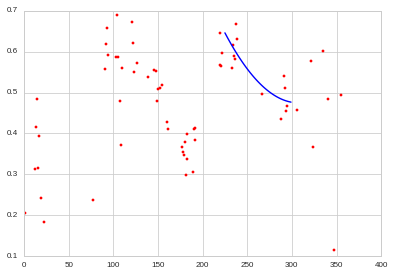

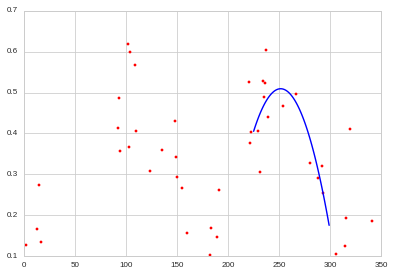

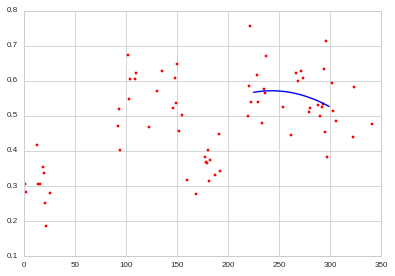

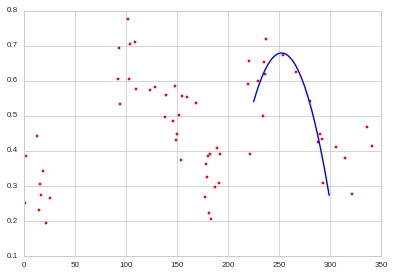

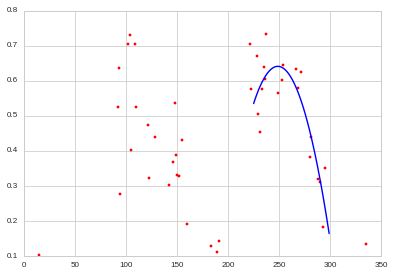

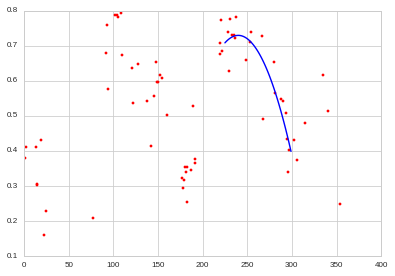

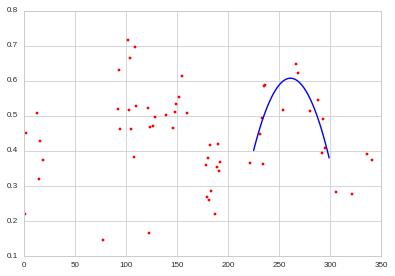

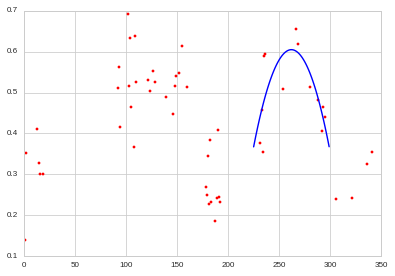

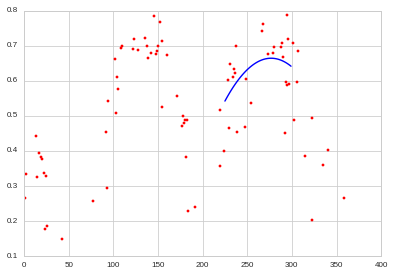

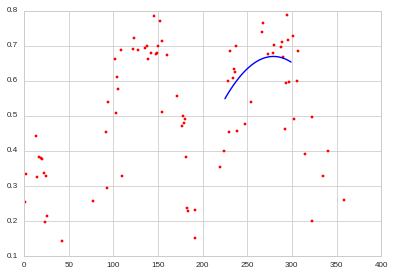

In [56]:
# select_keys = ['045840-p01']
# select_ind = np.where(crop_yield_field.index.values == '045840-p01')[0]
select_ind = np.where(ts_data.max(axis=1)<0.8)[0]
select_keys = ts_data.index[select_ind]

print peak_y[select_ind], crop_yield_field.loc[select_keys, 'yield_field']
for i, k in zip(select_ind, select_keys):
    fig, ax = plt.subplots()
    # ts_section = ts_data.loc[k, beg_doy:end_doy]
    ts_section = ts_data.loc[k, :]
    tmp_ind = np.where(ts_section != no_data)[0]
    y = ts_section.values[tmp_ind]
    x = ts_section.index.values[tmp_ind]
    ax.plot(x, y, '.r')
    xfit = np.arange(beg_doy, end_doy)
    ax.plot(xfit, quad_func[i](xfit), '-b')

134
30
0.317481850139
[ 27568.07556292 -20806.53668422] coef[0]*x+coef[1]
220
35
0.243809137108
[ 22457.6860527  -16334.31512979] coef[0]*x+coef[1]


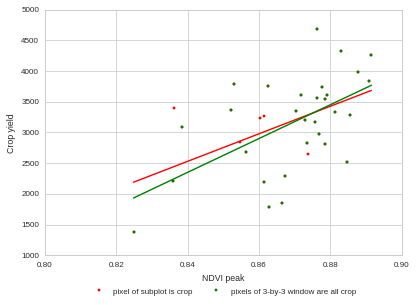

In [120]:
# valid_flag = np.logical_or(reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>max_y, crop_pix_flag)), pix_frac_flag)
valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>=max_y, crop_pix_flag))
# valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>max_y))
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
print len(valid_keys)

x = peak_y[valid_ind]
y = crop_yield_field.loc[valid_keys, 'yield_field'].values
coef = np.polyfit(x, y, 1)
reg_func = np.poly1d(coef)

r2 = 1 - np.sum((y - reg_func(x))**2)/np.sum((y - np.mean(y))**2)
print r2
print coef, "coef[0]*x+coef[1]"

xfit = np.array([np.min(x), np.max(x)])
yfit = reg_func(xfit)

single_valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>=max_y, single_crop_pix_flag))
single_valid_ind = np.where(single_valid_flag)[0]
single_valid_keys = ts_data.index.values[single_valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_valid_keys)

x = peak_y[single_valid_ind]
y = crop_yield_field.loc[single_valid_keys, 'yield_field'].values
coef = np.polyfit(x, y, 1)
reg_func = np.poly1d(coef)

r2 = 1 - np.sum((y - reg_func(x))**2)/np.sum((y - np.mean(y))**2)
print r2
print coef, "coef[0]*x+coef[1]"

single_xfit = np.array([np.min(x), np.max(x)])
single_yfit = reg_func(single_xfit)

fig, ax = plt.subplots()
ax.plot(peak_y[single_valid_ind], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(peak_y[valid_ind], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')# 
ax.plot(single_xfit, single_yfit, '-r')
ax.plot(xfit, yfit, '-g')
plt.setp(ax, xlim=(0.8, 0.9))
# ax.set_title('NDVI fuse Terra + Landsat Obs., Quadratic fitting to TS section from 220 to 300, Pure crop pixel')
plt.setp(ax, xlabel='NDVI peak', ylabel='Crop yield')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_ndvi_vs_yield_tsfilter.png', dpi=300, bbox_inches='tight', pad_inches=0.)

134
134
0.0522525733504
[ -546.00373866  3738.52105333] coef[0]*x+coef[1]
220
220
0.0279802866248
[ -494.48434821  3662.50946262] coef[0]*x+coef[1]


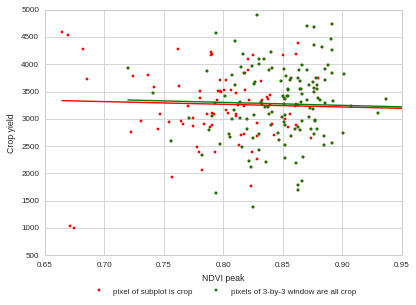

In [63]:
# valid_flag = np.logical_or(reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>max_y, crop_pix_flag)), pix_frac_flag)
valid_flag = crop_pix_flag
# valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>max_y))
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
print len(valid_keys)

x = peak_y[valid_ind]
y = crop_yield_field.loc[valid_keys, 'yield_field'].values
coef = np.polyfit(x, y, 1)
reg_func = np.poly1d(coef)

r2 = 1 - np.sum((y - reg_func(x))**2)/np.sum((y - np.mean(y))**2)
print r2
print coef, "coef[0]*x+coef[1]"

xfit = np.array([np.min(x), np.max(x)])
yfit = reg_func(xfit)

single_valid_flag = single_crop_pix_flag
single_valid_ind = np.where(single_valid_flag)[0]
single_valid_keys = ts_data.index.values[single_valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_valid_keys)

x = peak_y[single_valid_ind]
y = crop_yield_field.loc[single_valid_keys, 'yield_field'].values
coef = np.polyfit(x, y, 1)
reg_func = np.poly1d(coef)

r2 = 1 - np.sum((y - reg_func(x))**2)/np.sum((y - np.mean(y))**2)
print r2
print coef, "coef[0]*x+coef[1]"

single_xfit = np.array([np.min(x), np.max(x)])
single_yfit = reg_func(single_xfit)

fig, ax = plt.subplots()
ax.plot(peak_y[single_valid_ind], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(peak_y[valid_ind], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')# 
ax.plot(single_xfit, single_yfit, '-r')
ax.plot(xfit, yfit, '-g')
plt.setp(ax, xlim=(0.65, 0.95))
# ax.set_title('NDVI fuse Terra + Landsat Obs., Quadratic fitting to TS section from 220 to 300, Pure crop pixel')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.setp(ax, xlabel='NDVI peak', ylabel='Crop yield')
plt.savefig('../figures/reg_ndvi_vs_yield_no_tsfilter.png', dpi=300, bbox_inches='tight', pad_inches=0.)

In [ ]:
select_keys = valid_keys[np.where(peak_y[valid_ind]<0.7)[0]]
select_ind = np.where(np.in1d(ts_data.index, select_keys))[0]

In [ ]:
print select_ind, select_keys

In [ ]:
select_flag = [k.find('031939')>-1 for k in ts_data.index.values]
select_ind = np.where(select_flag)[0]
select_keys = ts_data.index[select_ind]
print select_ind, select_keys
print np.in1d(select_keys, valid_keys)

In [ ]:
for i, k in zip(select_ind, select_keys):
    fig, ax = plt.subplots()
    ts_section = ts_data.loc[k, beg_doy:end_doy]
    tmp_ind = np.where(ts_section != no_data)[0]
    y = ts_section.values[tmp_ind]
    x = ts_section.index.values[tmp_ind]
    
    print geo_points.loc[k, :], x, y, np.max(y)
    
    ax.plot(x, y, '.r')
    xfit = np.arange(beg_doy, end_doy)
    ax.plot(xfit, quad_func[i](xfit), '-b')

## Plot NDVI SG fit peak against cropy yield

In [ ]:
ts_data = ts_ndvi_sg
valid_flag = reduce(np.logical_and, ((ts_data!=no_data).all(axis=1), crop_pix_flag))
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print len(valid_keys)

x = ts_data.loc[valid_keys, 200:300].max(axis=1)
y = crop_yield_field.loc[valid_keys, 'yield_field'].values
coef = np.polyfit(x, y, 1)
reg_func = np.poly1d(coef)
yfit = reg_func(x)
r2 = 1 - np.sum((y - yfit)**2)/np.sum((y - np.mean(y))**2)
print r2

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y, '.b')
ax.plot(x, yfit, '-k')
plt.setp(ax, xlim=(0.7, 1))
ax.set_title('NDVI SG fit peak of 200 to 300, Pure crop pixel')
plt.savefig('../figures/reg_ndvi_vs_yield.png', dpi=300, bbox_inches='tight', pad_inches=0.)

## Plot ALOS data

In [72]:
print ts_alos_hh.head()
print crop_yield_field.head()

             175   203    259   287
full_id                            
004622-p02  2429  1232   3061  1752
004622-p04  1802  1570   3505  2789
004622-p08  1232  1323   3096  2802
004622-p10  1156  1659   3223  2893
011504-p01  3486  5787  10848  8816
            mesh_id plot_id     lat_m      lon_m      lat_s       lon_s  \
full_id                                                                   
004622-p02     4622     p02  20.70122  106.32945  20.700968  106.327124   
004622-p04     4622     p04  20.70122  106.32945  20.701456  106.327954   
004622-p08     4622     p08  20.70122  106.32945  20.701401  106.328430   
004622-p10     4622     p10  20.70122  106.32945  20.701609  106.328702   
011504-p01    11504     p01  20.65982  106.29705  20.660043  106.296676   

             variety  yield_field  
full_id                            
004622-p02       Nep  2398.245052  
004622-p04      BC15  3473.247317  
004622-p08       Nep  1641.749412  
004622-p10      BC15  2588.439197  
011504

134
134
220
220


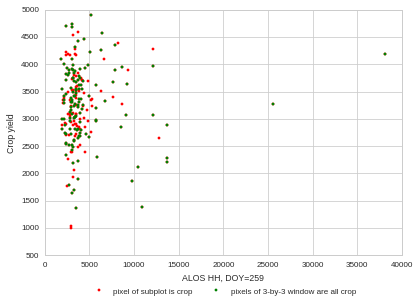

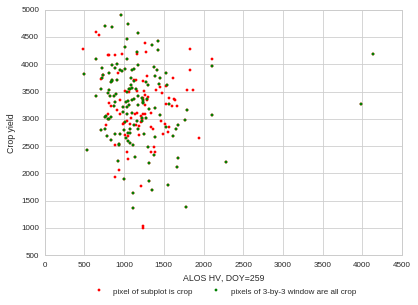

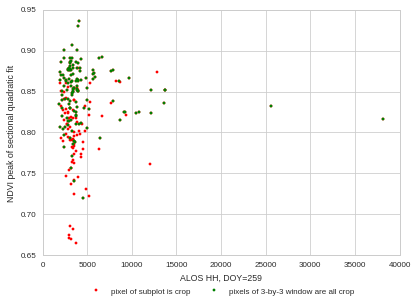

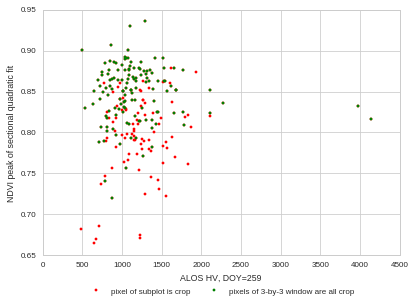

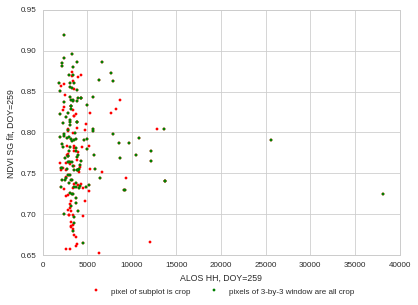

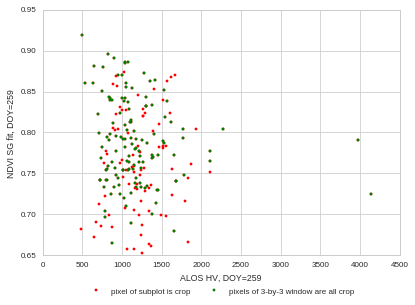

In [116]:
doy = 259

valid_flag = crop_pix_flag
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
print len(valid_keys)

single_valid_flag = single_crop_pix_flag
single_valid_ind = np.where(single_valid_flag)[0]
single_valid_keys = ts_data.index.values[single_valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_valid_keys)

fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='Crop yield')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hh_vs_yield.png', dpi=300, bbox_inches='tight', pad_inches=0.)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='Crop yield')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hv_vs_yield.png', dpi=300, bbox_inches='tight', pad_inches=0.)

fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], peak_y[single_valid_ind], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], peak_y[valid_ind], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='NDVI peak of sectional quadratic fit', ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hh_vs_ndvi_quad_peak.png', dpi=300, bbox_inches='tight', pad_inches=0.)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], peak_y[single_valid_ind], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], peak_y[valid_ind], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='NDVI peak of sectional quadratic fit', ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hv_vs_ndvi_quad_peak.png', dpi=300, bbox_inches='tight', pad_inches=0.)


fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], ts_ndvi_sg.loc[single_valid_keys, doy], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], ts_ndvi_sg.loc[valid_keys, doy], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='NDVI SG fit, DOY={0:d}'.format(doy), ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hh_vs_ndvi_sg.png', dpi=300, bbox_inches='tight', pad_inches=0.)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], ts_ndvi_sg.loc[single_valid_keys, doy], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], ts_ndvi_sg.loc[valid_keys, doy], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='NDVI SG fit, DOY={0:d}'.format(doy), ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hv_vs_ndvi_sg.png', dpi=300, bbox_inches='tight', pad_inches=0.)

134
30
220
35


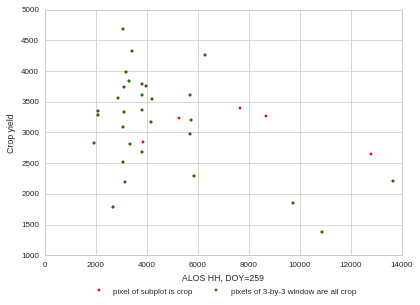

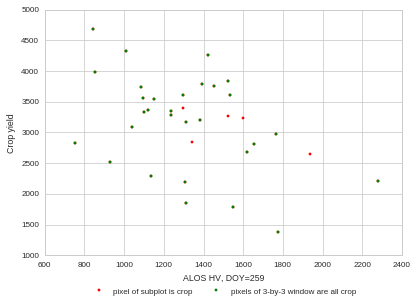

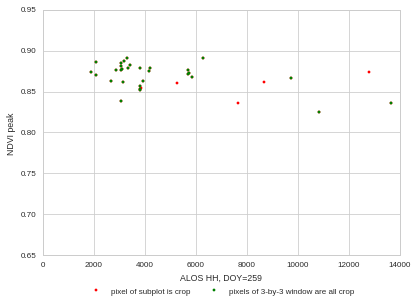

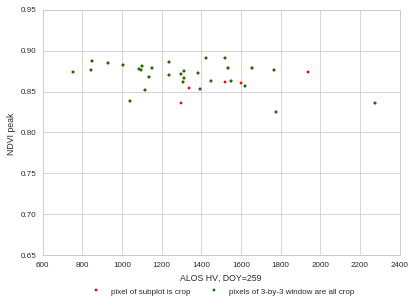

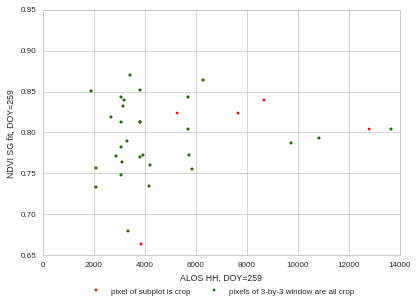

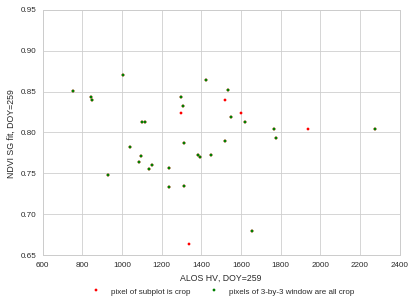

In [88]:
doy = 259

valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>=max_y, crop_pix_flag))
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
print len(valid_keys)

single_valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>=max_y, single_crop_pix_flag))
single_valid_ind = np.where(single_valid_flag)[0]
single_valid_keys = ts_data.index.values[single_valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_valid_keys)

fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='Crop yield')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='Crop yield')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], peak_y[single_valid_ind], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], peak_y[valid_ind], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='NDVI peak', ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], peak_y[single_valid_ind], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], peak_y[valid_ind], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='NDVI peak', ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)


fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], ts_ndvi_sg.loc[single_valid_keys, doy], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], ts_ndvi_sg.loc[valid_keys, doy], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='NDVI SG fit, DOY={0:d}'.format(doy), ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], ts_ndvi_sg.loc[single_valid_keys, doy], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], ts_ndvi_sg.loc[valid_keys, doy], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='NDVI SG fit, DOY={0:d}'.format(doy), ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)